### MODIS model 6 cloud phase information

This notebook maps the phase dataset available from the [MODIS atmosphere cloud product](https://modis-atmos.gsfc.nasa.gov/index.html) and plots it using a 5 color colormap

In [1]:
from IPython.display import Image
from e582utils.data_read import download
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from e582lib.radiation import planckInvert
import numpy as np
import matplotlib
import warnings
import h5py
from matplotlib.colors import ListedColormap
import seaborn as sns

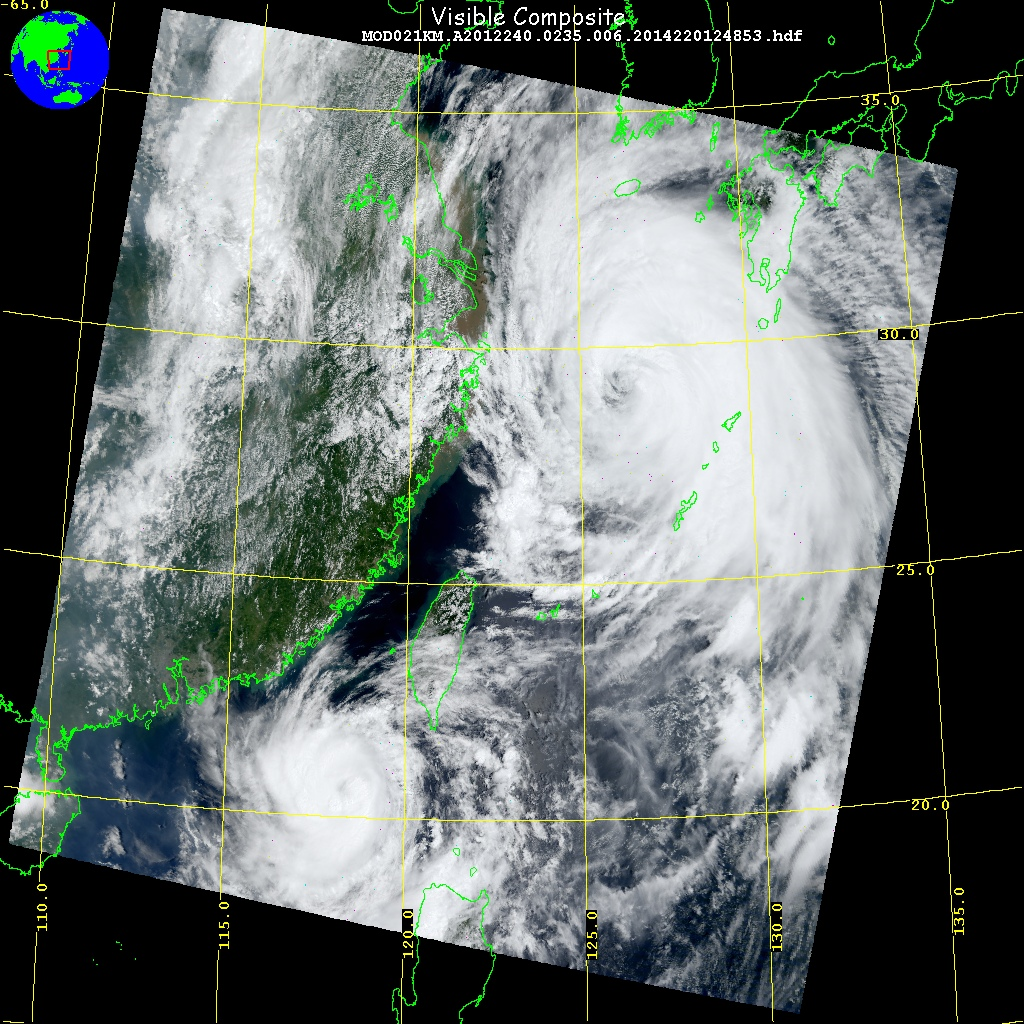

In [2]:
Image('MOBRGB.A2012240.0235.006.2015311151021.jpg',width=800)

### get the geometry and the model 6 cloud product files

In [3]:
geom_file='MOD03.A2012240.0235.006.2012287184700.h5'
cloud_file='MOD06_L2.A2012240.0235.006.2015062132158.h5'
files=[geom_file,cloud_file]
for the_file in files:
    download(the_file)

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MOD03.A2012240.0235.006.2012287184700.h5
writing to: MOD03.A2012240.0235.006.2012287184700.h5

MOD03.A2012240.0235.006.2012287184700.h5 already exists
and is 32287802 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MOD06_L2.A2012240.0235.006.2015062132158.h5
writing to: MOD06_L2.A2012240.0235.006.2015062132158.h5

MOD06_L2.A2012240.0235.006.2015062132158.h5 already exists
and is 159230828 bytes
will not overwrite



### extract the lats and lons and the phase -- mapping the number 6 to the number 4

if all pixels are numbered 0-4 it  makes it easier to display a 5 color map

In [4]:
 with h5py.File(geom_file) as geom_h5,h5py.File(cloud_file) as cloud_h5:        
        lon_data=geom_h5['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][...]
        lat_data=geom_h5['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][...]
        phase=cloud_h5['mod06']['Data Fields']['Cloud_Phase_Infrared_1km'][...]
        hit=phase==6
        phase[hit]=4
        
        


### pick our five colors from the seaborn xkcd database

Create a 5 color ListedColormap with the named colors

In [5]:
colors = ["royal blue", "baby blue", "eggshell", "burnt red", "soft pink"]
print([the_color for the_color in colors])
colors=[sns.xkcd_rgb[the_color] for the_color in colors]
pal=ListedColormap(colors,N=5)

['royal blue', 'baby blue', 'eggshell', 'burnt red', 'soft pink']


### plot the raw unprojected image for reference

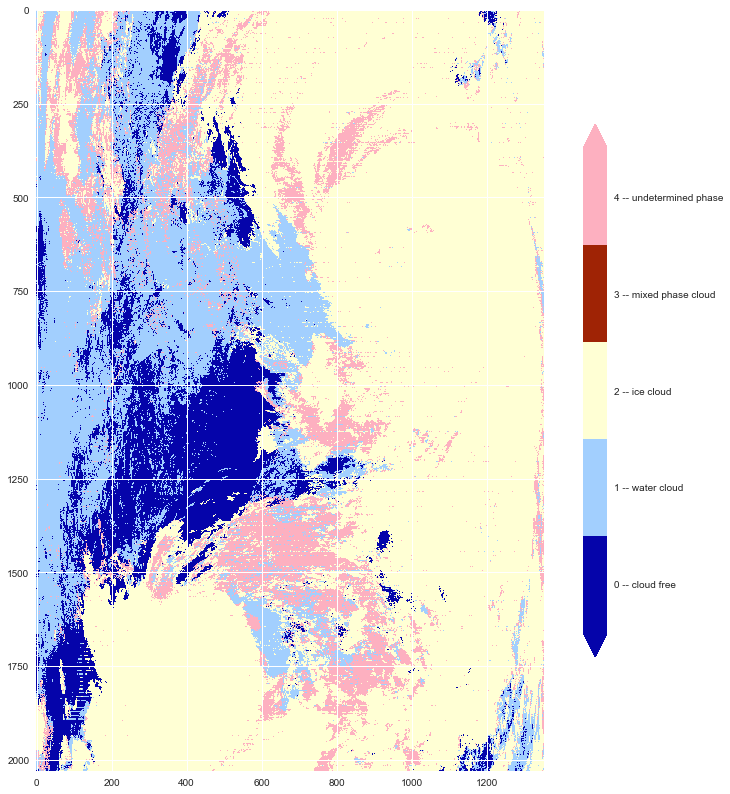

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(14,14))
CS=ax.imshow(phase,cmap=pal)
cax,kw = matplotlib.colorbar.make_axes(ax,location='right',pad=0.05,shrink=0.7)
cax=fig.colorbar(CS,cax=cax,extend='both',**kw);
labels='0 -- cloud free,1 -- water cloud,2 -- ice cloud,3 -- mixed phase cloud,4 -- undetermined phase'
labels=labels.split(',')
ends=np.linspace(0,4,6)
centers=(ends[1:] + ends[:-1])/2.
cax.set_ticks(centers)
cax.set_ticklabels(labels)

### resample the phase onto a laea projection

first convert the integers to floating point so we can get fractional values for mixed pixels
when we remap

In [7]:
phase=phase.astype(np.float32)

In [10]:
from e582lib.channels_reproject import resample_channels
from e582lib.channels_reproject import find_corners
corner_dict=find_corners(lat_data,lon_data)
result_dict=resample_channels(phase, lat_data, lon_data,corner_dict)
phase_gridded=result_dict['channels']
hit= phase_gridded==result_dict['fill_value']
phase_gridded[hit]=np.nan

pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '26.2433128356934', 'lon_0': '122.9773559570312', 'proj': 'laea', 'units': 'm'}
Number of columns: 2097
Number of rows: 1801
Area extent: (-1488679.7621463982, -1097636.0614290328, 1237900.6094383339, 1243801.7355623946)


x and y pixel dimensions in meters:
1300.2290756245743
1300.0765113778054

completed channels_resample


### map the gridded phase array

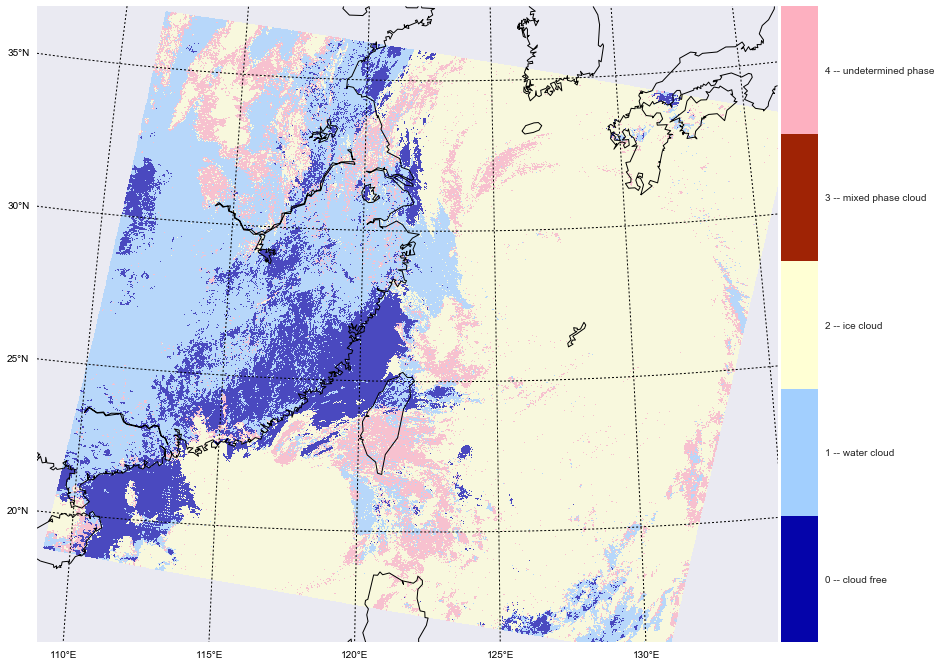

In [12]:
from e582lib.map_slices import make_basemap_xy
transform=result_dict['geotiff_args']['affine_transform']
basemap_args=result_dict['basemap_args']
fig,ax=plt.subplots(1,1,figsize=(14,14))
basemap_args['ax']=ax
basemap_args['resolution']='l'
bmap=Basemap(**basemap_args)
height,width=phase_gridded.shape
xvals,yvals=make_basemap_xy(0,height,0,width,bmap,transform)
cax=bmap.colorbar(CS,'right',pad=0.05);
cax.set_ticks(centers)
cax.set_ticklabels(labels)
bmap.imshow(phase_gridded,origin='upper',cmap=pal,alpha=0.7)
bmap.drawcoastlines()
lat_sep,lon_sep= 5,5
parallels = np.arange(10, 60, lat_sep)
meridians = np.arange(-180, 180, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                       fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90);